# Hand Engineered Features - LBP feature from Chest radiographs.



***Steps to get started***

Execute this notebook in Kaggle. 
Login to Kaggle account and click on "New Notebook".
From File menu, select "Import notebook", and drag and drop this notebook file to it.
Click on any cell to start session.
On the right pane, you will find "Add Data" . On the search icon give the below url (of the dataset) and select this dataset from the search results. Click the "+" icon to add this dataset to your notebook session.

Dataset - https://www.kaggle.com/datasets/kmader/pulmonary-chest-xray-abnormalities

In [1]:
# Importing the libraries

import pandas as pd
import numpy as np

import os
import cv2

import imageio
import skimage
import skimage.io
import skimage.transform

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


import matplotlib.style  as style


from sklearn.linear_model      import LogisticRegression
from sklearn.model_selection   import train_test_split


from skimage.io import imread, imshow
from skimage.transform import resize
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
os.listdir('../input')

['pulmonary-chest-xray-abnormalities']

In [3]:
os.listdir('../input/pulmonary-chest-xray-abnormalities')

['ChinaSet_AllFiles', 'Montgomery']

In [4]:
shen_image_list = os.listdir('../input/pulmonary-chest-xray-abnormalities/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png')
mont_image_list = os.listdir('../input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/CXR_png')

In [5]:
df_shen = pd.DataFrame(shen_image_list, columns=['image_id'])

In [6]:
df_shen.head()

,image_id
0,CHNCXR_0092_0.png
1,CHNCXR_0322_0.png
2,CHNCXR_0304_0.png
3,CHNCXR_0572_1.png
4,CHNCXR_0547_1.png


In [7]:
df_shen.shape

(663, 1)

In [8]:
df_shen = df_shen[df_shen['image_id'] != 'Thumbs.db']
df_shen

,image_id
0,CHNCXR_0092_0.png
1,CHNCXR_0322_0.png
2,CHNCXR_0304_0.png
3,CHNCXR_0572_1.png
4,CHNCXR_0547_1.png
...,...
658,CHNCXR_0321_0.png
659,CHNCXR_0080_0.png
660,CHNCXR_0569_1.png
661,CHNCXR_0107_0.png


In [9]:
df_shen.head()

,image_id
0,CHNCXR_0092_0.png
1,CHNCXR_0322_0.png
2,CHNCXR_0304_0.png
3,CHNCXR_0572_1.png
4,CHNCXR_0547_1.png


In [10]:
df_shen.shape

(662, 1)

In [11]:
# put the images into dataframes
df_shen = pd.DataFrame(shen_image_list, columns=['image_id'])
df_mont = pd.DataFrame(mont_image_list, columns=['image_id'])

# remove the 'Thunbs.db' line
df_shen = df_shen[df_shen['image_id'] != 'Thumbs.db']
df_mont = df_mont[df_mont['image_id'] != 'Thumbs.db']

# Reset the index or this will cause an error later
df_shen.reset_index(inplace=True, drop=True)
df_mont.reset_index(inplace=True, drop=True)

print(df_shen.shape)
print(df_mont.shape)

(662, 1)
(138, 1)


In [12]:
df_shen.head()

,image_id
0,CHNCXR_0092_0.png
1,CHNCXR_0322_0.png
2,CHNCXR_0304_0.png
3,CHNCXR_0572_1.png
4,CHNCXR_0547_1.png


In [13]:
df_mont.head()

,image_id
0,MCUCXR_0017_0.png
1,MCUCXR_0020_0.png
2,MCUCXR_0030_0.png
3,MCUCXR_0013_0.png
4,MCUCXR_0354_1.png


In [14]:
# Function to select the 4th index from the end of the string (file name)
# example: CHNCXR_0470_1.png --> 1 is the label, meaning TB is present.

def extract_target(x):
    target = int(x[-5])
    if target == 0:
        return 'Normal'
    if target == 1:
        return 'Tuberculosis'

In [15]:
# Assign the target labels

df_shen['target'] = df_shen['image_id'].apply(extract_target)

df_mont['target'] = df_mont['image_id'].apply(extract_target)

In [16]:
# Shenzen Dataset

df_shen['target'].value_counts()

Tuberculosis    336
Normal          326
Name: target, dtype: int64

In [17]:
# Montgomery Dataset

df_mont['target'].value_counts()

Normal          80
Tuberculosis    58
Name: target, dtype: int64

Function to display the images in datasets

In [18]:
# # source: https://www.kaggle.com/gpreda/honey-bee-subspecies-classification

def draw_category_images(col_name,figure_cols, df, IMAGE_PATH):
    
    """
    Give a column in a dataframe,
    this function takes a sample of each class and displays that
    sample on one row. The sample size is the same as figure_cols which
    is the number of columns in the figure.
    Because this function takes a random sample, each time the function is run it
    displays different images.
    """
    

    categories = (df.groupby([col_name])[col_name].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols, 
                         figsize=(4*figure_cols,4*len(categories))) # adjust size here
    # draw a number of images for each location
    for i, cat in enumerate(categories):
        sample = df[df[col_name]==cat].sample(figure_cols) # figure_cols is also the sample size
        for j in range(0,figure_cols):
            file=IMAGE_PATH + sample.iloc[j]['image_id']
            im=imageio.imread(file)
            ax[i, j].imshow(im, resample=True, cmap='gray')
            ax[i, j].set_title(cat, fontsize=14)  
    plt.tight_layout()
    plt.show()
    

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.


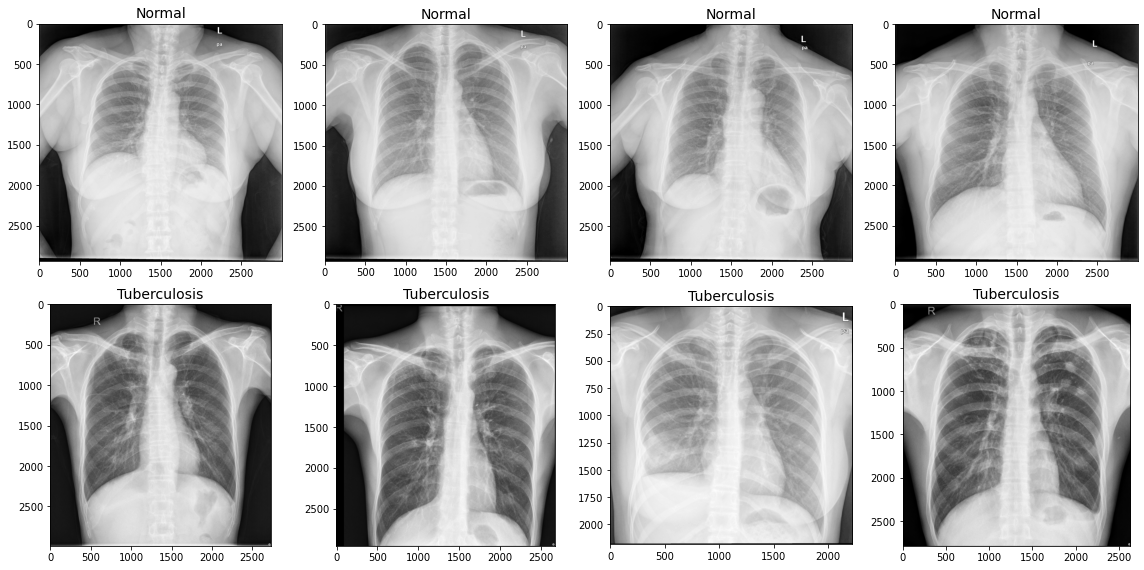

In [19]:
## Shenzen Dataset

IMAGE_PATH = '../input/pulmonary-chest-xray-abnormalities/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png/' 

draw_category_images('target',4, df_shen, IMAGE_PATH)

Visualizing the montgomer dataset images

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.


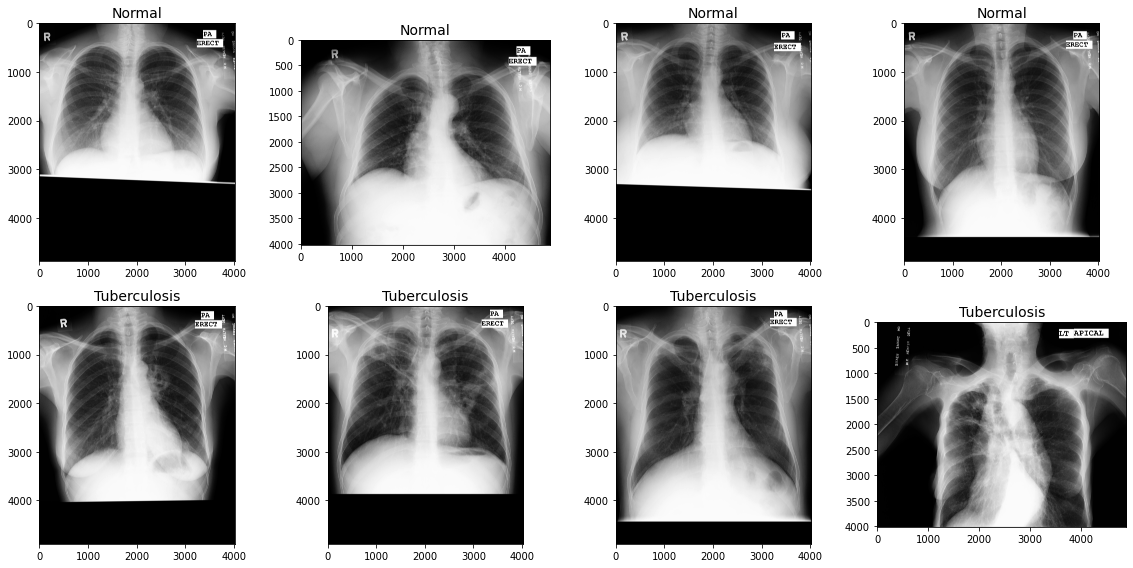

In [20]:
# #Montgomery Dataset

IMAGE_PATH = '../input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/CXR_png/'

draw_category_images('target',4, df_mont, IMAGE_PATH)

# EDA Exploratory Data Analysis

In [21]:
#EDA

def read_image_sizes(file_name):
    """
    1. Get the shape of the image
    2. Get the min and max pixel values in the image.
    Getting pixel values will tell if any pre-processing has been done.
    3. This info will be added to the original dataframe.
    """
    image = cv2.imread(IMAGE_PATH + file_name)
    max_pixel_val = image.max()
    min_pixel_val = image.min()
    
    # image.shape[2] represents the number of channels: (height, width, num_channels).
    # Here we are saying: If the shape does not have a value for num_channels (height, width)
    # then assign 1 to the number of channels.
    if len(image.shape) > 2: # i.e. more than two numbers in the tuple
        output = [image.shape[0], image.shape[1], image.shape[2], max_pixel_val, min_pixel_val]
    else:
        output = [image.shape[0], image.shape[1], 1, max_pixel_val, min_pixel_val]
    return output


In [22]:
# w = width, h= height, c= number of channels of image
IMAGE_PATH = '../input/pulmonary-chest-xray-abnormalities/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png/'

m = np.stack(df_shen['image_id'].apply(read_image_sizes))
df = pd.DataFrame(m,columns=['w','h','c','max_pixel_val','min_pixel_val'])
df_shen = pd.concat([df_shen,df],axis=1, sort=False)

df_shen.head()

,image_id,target,w,h,c,max_pixel_val,min_pixel_val
0,CHNCXR_0092_0.png,Normal,2652,2796,3,255,0
1,CHNCXR_0322_0.png,Normal,2949,3000,3,255,0
2,CHNCXR_0304_0.png,Normal,2945,3000,3,255,0
3,CHNCXR_0572_1.png,Tuberculosis,2289,2400,3,255,0
4,CHNCXR_0547_1.png,Tuberculosis,2823,2610,3,255,0


In [23]:
# w = width, h= height, c= number of channels of image; for Montgomery
IMAGE_PATH = '../input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/CXR_png/'

m = np.stack(df_mont['image_id'].apply(read_image_sizes))
df = pd.DataFrame(m,columns=['w','h','c','max_pixel_val','min_pixel_val'])
df_mont = pd.concat([df_mont,df],axis=1, sort=False)

df_mont.head()

,image_id,target,w,h,c,max_pixel_val,min_pixel_val
0,MCUCXR_0017_0.png,Normal,4020,4892,3,255,0
1,MCUCXR_0020_0.png,Normal,4020,4892,3,255,0
2,MCUCXR_0030_0.png,Normal,4020,4892,3,255,0
3,MCUCXR_0013_0.png,Normal,4020,4892,3,255,0
4,MCUCXR_0354_1.png,Tuberculosis,4020,4892,3,252,0


In [24]:
df_shen['c'].value_counts()

3    662
Name: c, dtype: int64

In [25]:
df_mont['c'].value_counts()

3    138
Name: c, dtype: int64

In [26]:
df_mont['target'].value_counts()

Normal          80
Tuberculosis    58
Name: target, dtype: int64

In [27]:
### Combine the two dataframes and shuffle

df_data = pd.concat([df_shen, df_mont], axis=0).reset_index(drop=True)

df_data = shuffle(df_data)


df_data.shape

(800, 7)

Label creation

In [28]:
# Create a new column called 'labels' that maps the classes to binary values.
df_data['labels'] = df_data['target'].map({'Normal':0, 'Tuberculosis':1})

In [29]:
df_data.head()

,image_id,target,w,h,c,max_pixel_val,min_pixel_val,labels
382,CHNCXR_0311_0.png,Normal,2955,3000,3,255,0,0
448,CHNCXR_0282_0.png,Normal,2967,3000,3,255,0,0
181,CHNCXR_0446_1.png,Tuberculosis,2925,3000,3,255,0,1
672,MCUCXR_0063_0.png,Normal,4892,4020,3,255,0,0
171,CHNCXR_0365_1.png,Tuberculosis,2808,2458,3,255,0,1


Splitting data into train and test split

In [30]:
# train_test_split

y = df_data['labels']

df_train, df_val = train_test_split(df_data, test_size=0.15, random_state=101, stratify=y)

print(df_train.shape)
print(df_val.shape)

(680, 8)
(120, 8)


In [31]:
df_train['target'].value_counts()

Normal          345
Tuberculosis    335
Name: target, dtype: int64

In [32]:
df_train.head()

,image_id,target,w,h,c,max_pixel_val,min_pixel_val,labels
354,CHNCXR_0412_1.png,Tuberculosis,2943,2993,3,255,0,1
792,MCUCXR_0028_0.png,Normal,4892,4020,3,255,0,0
784,MCUCXR_0218_1.png,Tuberculosis,4892,4020,3,255,0,1
596,CHNCXR_0338_1.png,Tuberculosis,2924,2397,3,255,0,1
4,CHNCXR_0547_1.png,Tuberculosis,2823,2610,3,255,0,1


In [33]:
df_val['target'].value_counts()

Normal          61
Tuberculosis    59
Name: target, dtype: int64

CREATE FOLDERS INSIDE THE BASE DIRECTORY - to arrange train images and validation images in respective folders

In [34]:
# Create a new directory
base_dir = 'base_dir'
os.mkdir(base_dir)


#[CREATE FOLDERS INSIDE THE BASE DIRECTORY]

# now we create 2 folders inside 'base_dir':

# train
    # Normal
    # Tuberculosis

# val
    # Normal
    # Tuberculosis


# create a path to 'base_dir' to which we will join the names of the new folders
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)


# [CREATE FOLDERS INSIDE THE TRAIN AND VALIDATION FOLDERS]
# Inside each folder we create seperate folders for each class

# create new folders inside train_dir
Normal = os.path.join(train_dir, 'Normal')
os.mkdir(Normal)
Tuberculosis = os.path.join(train_dir, 'Tuberculosis')
os.mkdir(Tuberculosis)


# create new folders inside val_dir
Normal = os.path.join(val_dir, 'Normal')
os.mkdir(Normal)
Tuberculosis = os.path.join(val_dir, 'Tuberculosis')
os.mkdir(Tuberculosis)


In [35]:
# Set the image_id as the index in df_data
df_data.set_index('image_id', inplace=True)

In [36]:
# We will resize the images to 299 x 299 
IMAGE_HEIGHT = 299
IMAGE_WIDTH = 299

In [37]:
# Get a list of images in each of the two folders
folder_1 = os.listdir('../input/pulmonary-chest-xray-abnormalities/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png')
folder_2 = os.listdir('../input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/CXR_png')

# Get a list of train and val images
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])



# Transfer the train images

for image in train_list:
    
    fname = image
    label = df_data.loc[image,'target']
    
    if fname in folder_1:
        # source path to image
        src = os.path.join('../input/pulmonary-chest-xray-abnormalities/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        
        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # save the image at the destination
        cv2.imwrite(dst, image)
        #shutil.copyfile(src, dst)

    if fname in folder_2:
        # source path to image
        src = os.path.join('../input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/CXR_png', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        
        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # save the image at the destination
        cv2.imwrite(dst, image)
        
        # copy the image from the source to the destination
        #shutil.copyfile(src, dst)


# Transfer the val images

for image in val_list:
    
    fname = image
    label = df_data.loc[image,'target']
    
    if fname in folder_1:
        # source path to image
        src = os.path.join('../input/pulmonary-chest-xray-abnormalities/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        
        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # save the image at the destination
        cv2.imwrite(dst, image)
        
        # copy the image from the source to the destination
        #shutil.copyfile(src, dst)

    if fname in folder_2:
        # source path to image
        src = os.path.join('../input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/CXR_png', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        
        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # save the image at the destination
        cv2.imwrite(dst, image)
        
        # copy the image from the source to the destination
        #shutil.copyfile(src, dst)

In [38]:
# check how many train images we have in each folder

print(len(os.listdir('base_dir/train_dir/Normal')))
print(len(os.listdir('base_dir/train_dir/Tuberculosis')))

345
335


In [39]:
# check how many val images we have in each folder

print(len(os.listdir('base_dir/val_dir/Normal')))
print(len(os.listdir('base_dir/val_dir/Tuberculosis')))

61
59


# Rotation Invariant Augmentation in one step, without using keras aug steps

In [40]:
import os
import random
import numpy as np
from scipy import ndarray

# image processing library
import skimage as sk
from skimage import transform
from skimage import util
from skimage import io
import cv2
import skimage.io
import skimage.transform

def gkernel(l=3, sig=0.3):
    """\
    Gaussian Kernel Creator via given length and sigma
    """

    ax = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
    xx, yy = np.meshgrid(ax, ax)

    kernel = np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(sig))

    return kernel / np.sum(kernel)



def shear(image_array: ndarray):
  rows, cols, dim = image_array.shape
  # transformation matrix for Shearing
  # shearing applied to x-axis
  # shear value as given in paper 0.2 and 0.4
  M = np.float32([[1, 0, 0],
              [0.2, 1  , 0],
              [0, 0  , 1]])
  # shearing applied to y-axis
  M = np.float32([[1,   0, 0],
                  [0.4, 1, 0],
                  [0,   0, 1]])
  # apply a perspective transformation to the image                
  sheared_img = cv2.warpPerspective(image_array,M,(int(cols*1.5),int(rows*1.5)))
  return sheared_img  


def gaus_filt(gray, g_kernel = gkernel(3,2)):
  gaus = cv2.filter2D(gray,-1,g_kernel) #convolve kernel with image
  return gaus     


    
# dictionary of the transformations; The Rotation Invariant Augmentations mentioned in paper
available_transformations = {
    'shear transformation': shear,
    'gausssian filtering': gaus_filt,
  }

folder_path = 'base_dir/train_dir/Normal'
num_files_desired = 1500

# find all files paths from the folder
images = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

num_generated_files = 0
while num_generated_files <= num_files_desired:
    # random image from the folder
    image_path = random.choice(images)
    # read image as an two dimensional array of pixels
    image_to_transform = sk.io.imread(image_path)

    image_to_transform = cv2.cvtColor(image_to_transform, cv2.COLOR_BGR2RGB)
    image_to_transform = sk.transform.resize(image_to_transform, (299, 299, 3))        
    

    # random num of transformation to apply
    num_transformations_to_apply = random.randint(1, len(available_transformations))

    num_transformations = 0
    transformed_image = None
    while num_transformations <= num_transformations_to_apply:
        # random transformation to apply for a single image
        key = random.choice(list(available_transformations))
        transformed_image = available_transformations[key](image_to_transform)
        num_transformations += 1

        new_file_path = '%s/augmented_image_%s.jpg' % (folder_path, num_generated_files)

        # write image to the disk
        io.imsave(new_file_path, transformed_image)
    num_generated_files += 1

In [41]:
# Check how many train images we now have in folder.
# This is the original images plus the augmented images.
print(len(os.listdir('base_dir/train_dir/Normal')))

1846


In [42]:
# for Tuberculosis class

# dictionary of the transformations ; The Rotation Invariant Augmentations mentioned in paper
available_transformations = {
    'shear transformation': shear,
    'gausssian filtering': gaus_filt,
  }

folder_path = 'base_dir/train_dir/Tuberculosis'
num_files_desired = 1500

# find all files paths from the folder
images = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

num_generated_files = 0
while num_generated_files <= num_files_desired:
    # random image from the folder
    image_path = random.choice(images)
    # read image as an two dimensional array of pixels
    image_to_transform = sk.io.imread(image_path)
  
    image_to_transform = cv2.cvtColor(image_to_transform, cv2.COLOR_BGR2RGB)
    image_to_transform = sk.transform.resize(image_to_transform, (299, 299, 3))        
    
    # random num of transformation to apply
    num_transformations_to_apply = random.randint(1, len(available_transformations))

    num_transformations = 0
    transformed_image = None
    while num_transformations <= num_transformations_to_apply:
        # random transformation to apply for a single image
        key = random.choice(list(available_transformations))
        transformed_image = available_transformations[key](image_to_transform)
        num_transformations += 1

        new_file_path = '%s/augmented_image_%s.jpg' % (folder_path, num_generated_files)

        # write image to the disk
        io.imsave(new_file_path, transformed_image)
    num_generated_files += 1

In [43]:
# This is the original images plus the augmented images.
print(len(os.listdir('base_dir/train_dir/Tuberculosis')))

1836


In [44]:
#check how many val images we have in each folder.

print(len(os.listdir('base_dir/val_dir/Normal')))
print(len(os.listdir('base_dir/val_dir/Tuberculosis')))

61
59


To plot the augmented images in Normal class

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.


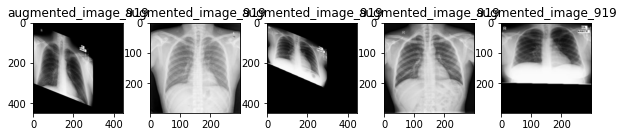

In [45]:
import glob
from PIL import Image
# Put all images in the folder into a list (works)
images = []
for f in glob.iglob('base_dir/train_dir/Normal/augmented_image_*'):
    images.append(np.asarray(Image.open(f)))
    #images = Image.fromarray(f)

# plot the images (works)
images = np.array(images)
fig, axs = plt.subplots(1, 5, figsize=(10, 50))
fig.subplots_adjust(hspace = .3, wspace=.3)
axs = axs.ravel()

# This is for displaying the names

for i in range(5):
    for filename in os.listdir('base_dir/train_dir/Normal/'):
      ClassName = filename[:-4]
      axs[i].imshow(images[i])
      axs[i].set_title(ClassName)
      

To plot the augmented images in Tuberculosis class

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.


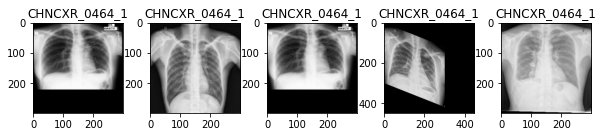

In [46]:
import glob
from PIL import Image
# Put all images in the folder into a list (works)
images = []
for f in glob.iglob('base_dir/train_dir/Tuberculosis/augmented_image_*'):
    images.append(np.asarray(Image.open(f)))
    #images = Image.fromarray(f)

# plot the images (works)
images = np.array(images)
fig, axs = plt.subplots(1, 5, figsize=(10, 50))
fig.subplots_adjust(hspace = .3, wspace=.3)
axs = axs.ravel()

# This is for displaying the names

for i in range(5):
    for filename in os.listdir('base_dir/train_dir/Tuberculosis/'):
      ClassName = filename[:-4]
      axs[i].imshow(images[i])
      axs[i].set_title(ClassName)

# Hand Engineered Feature - LBP

In [47]:
#importing required libraries
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import numpy as np
from matplotlib import pyplot as plt

In [48]:
def get_pixel(img, center, x, y):

    new_value = 0

    try:
        # If local neighbourhood pixel
        # value is greater than or equal
        # to center pixel values then
        # set it to 1
        if img[x][y] >= center:
            new_value = 1

    except:
        # Exception is required when
        # neighbourhood value of a center
        # pixel value is null i.e. values
        # present at boundaries.
        pass

    return new_value


# lbp function

In [49]:
import glob
import skimage

def loadImages(path):    


    sample = []
    
    for filename in glob.glob(path):
        
        imga = cv2.imread(filename)   
        
        
        # Function for calculating LBP
        def lbp_calculated_pixel(img, x, y):

            center = img[x][y]

            val_ar = []

            # top_left
            val_ar.append(get_pixel(img, center, x-1, y-1))

            # top
            val_ar.append(get_pixel(img, center, x-1, y))

            # top_right
            val_ar.append(get_pixel(img, center, x-1, y + 1))

            # right
            val_ar.append(get_pixel(img, center, x, y + 1))

            # bottom_right
            val_ar.append(get_pixel(img, center, x + 1, y + 1))

            # bottom
            val_ar.append(get_pixel(img, center, x + 1, y))

            # bottom_left
            val_ar.append(get_pixel(img, center, x + 1, y-1))

            # left
            val_ar.append(get_pixel(img, center, x, y-1))

            # Now, we need to convert binary
            # values to decimal
            power_val = [1, 2, 4, 8, 16, 32, 64, 128] #, 256, 512, 1024]

            val = 0

            for i in range(len(val_ar)):
                val += val_ar[i] * power_val[i]

            return val
        
        
        
        
        img_bgr = imga

        height, width, _ = img_bgr.shape
        x,y = height, width
            
        img_bgr = img_bgr.astype(np.float32, copy=False)        
        img_gray = cv2.cvtColor(img_bgr,cv2.COLOR_BGR2GRAY)       
        

        # Create a numpy array as the same height and width of RGB image
        img_lbp = np.zeros((height,width),
                        np.uint8)

        for i in range(0, height):
            for j in range(0, width):
                img_lbp[i, j] = lbp_calculated_pixel(img_gray, i, j)
                
        img_lbp = skimage.transform.resize(img_lbp, (299,299, 3))
        
        IMG = img_lbp
        sample.append(IMG)
        
        
    return sample

In [50]:
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'

train_path1 = 'base_dir/train_dir/Normal/*.png'
train_path2 = 'base_dir/train_dir/Tuberculosis/*.png'
train_path3 = 'base_dir/train_dir/Normal/augmented_image_*'
train_path4 = 'base_dir/train_dir/Tuberculosis/augmented_image_*'

valid_path1 = 'base_dir/val_dir/Normal/*.png'
valid_path2 = 'base_dir/val_dir/Tuberculosis/*.png'


In [51]:
train_N_aug = loadImages(train_path3) 
train_TB_aug= loadImages(train_path4)

In [52]:
valid_N = loadImages(valid_path1)
valid_TB = loadImages(valid_path2)

In [53]:
#%% CREATION OF DATASETS FOR FEATURE EXTRACTION

df_train_N_aug = pd.DataFrame({'image':train_N_aug, 'label': 'Normal'})
df_train_TB_aug = pd.DataFrame({'image':train_TB_aug, 'label': 'Tuberculosis'})


df_valid_N = pd.DataFrame({'image':valid_N, 'label': 'Normal'})
df_valid_TB = pd.DataFrame({'image':valid_TB, 'label': 'Tuberculosis'})

In [54]:
  
final_data = [df_train_N_aug, df_train_TB_aug, df_valid_N, df_valid_TB]
final_data = pd.concat(final_data)

print("Entire data size:",final_data.shape)

Entire data size: (3122, 2)


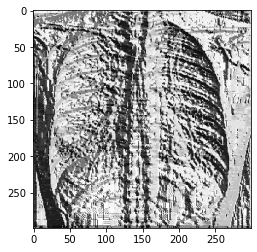

In [55]:
plt.imshow(df_train_N_aug['image'][50],cmap=plt.cm.gray)

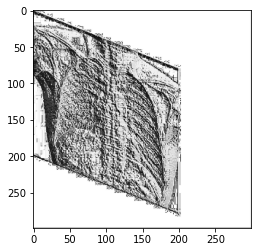

In [56]:
plt.imshow(df_train_TB_aug['image'][51],cmap=plt.cm.gray)

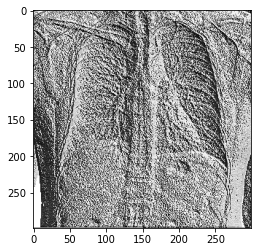

In [57]:
plt.imshow(df_valid_N['image'][50],cmap=plt.cm.gray)

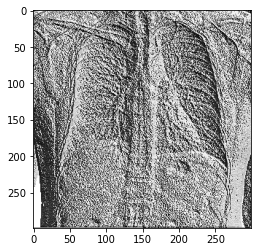

In [58]:
plt.imshow(df_valid_N['image'][50])

In [59]:
temp_N = df_train_N_aug.head(9)
temp_N.shape

(9, 2)

In [60]:
temp_TB = df_train_TB_aug.head(9)
temp_TB.shape

(9, 2)

In [61]:
## concat to get same length as ordinary aug hog

In [62]:
final_data = [temp_N,temp_TB,df_train_N_aug, df_train_TB_aug, df_valid_N, df_valid_TB]
final_data = pd.concat(final_data)

print("Entire data size:",final_data.shape)

Entire data size: (3140, 2)


In [63]:

#%% TRAIN LABEL SEPARATION

train_data = final_data['image']
labels = final_data['label']

In [64]:
#%% LOOKING AT THE AMOUNT OF ITEMS PER CLASS 

from collections import Counter
print("Labels Count:",Counter(np.array(labels)))

Labels Count: Counter({'Normal': 1571, 'Tuberculosis': 1569})


In [65]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [66]:
# ENCODING the LABELS

le = LabelEncoder()

final_data['label'] = le.fit_transform(final_data['label'])
final_data.head()

,image,label
0,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,...",0
1,"[[[0.7529411764705882, 0.7529411764705882, 0.7...",0
2,"[[[0.16275720204485492, 0.16275720204485492, 0...",0
3,"[[[0.24705882352941178, 0.24705882352941178, 0...",0
4,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,...",0


In [67]:
# for 3140 by adding 18 temp train
#%% SPLITTING INTO TRAIN AND TEST SET, TRAIN SET WILL BE FURTHER SPLIT INTO TRAIN AND VALIDATION SET
X_train, X_test, y_train, y_test = train_test_split(train_data, final_data['label'],
                                                  test_size = 0.2,
                                                  stratify = final_data['label'],
                                                  shuffle = True,
                                                  random_state = 42)

print('length X_train:', len(X_train))
print('length y_train:', len(y_train))

print('length X_test:',  len(X_test))
print('length y_test:', len(y_test))

length X_train: 2512
length y_train: 2512
length X_test: 628
length y_test: 628


In [68]:
X_train.shape

(2512,)

In [69]:
y_train.shape

(2512,)

In [70]:
X_test.shape

(628,)

In [71]:
y_test.shape

(628,)

In [72]:
X_train = np.array(X_train)
X_test = np.array(X_test)

In [73]:
X_train[1].shape

(299, 299, 3)

In [74]:
X_test[1].shape

(299, 299, 3)

In [82]:
x_train= np.empty((len(X_train),X_train[0].shape[0],X_train[0].shape[1]))  
for i,x in enumerate(X_train):
    x_train[i]=X_train[i]
print(x_train.shape)

ValueError: could not broadcast input array from shape (299,299,3) into shape (299,299)

In [97]:
x_test= np.empty((len(X_test),X_test[0].shape[0],X_test[0].shape[1])) # ,X_test[0].shape[2]
for i,x in enumerate(X_test):
    x_test[i]=X_test[i]
print(x_test.shape)

ValueError: could not broadcast input array from shape (299,299,3) into shape (299,299)

reshaping x-train and x_test for Logistic Regression model as it takes only 2D data.


nsamples, nx, ny = train_dataset.shape
d2_train_dataset = train_dataset.reshape((nsamples,nx*ny))

## in our case 
nsamples = 2512
nx= 299
ny =299

for x_test
nsamples = 628
nx= 299
ny = 299

## therefore

x_train.shape = 2512, 299,299
d2_x_train_dataset = x_train.reshape((2512, 299*299))

In [84]:
x_train = x_train.reshape((2512, 299*299))

In [85]:
x_train.shape

(2512, 89401)

## reshaping x_test

In [87]:
x_test = x_test.reshape((628, 299*299))

In [88]:
x_test.shape

(628, 89401)

# Training Logistic Regression Model with Hand Engineered LBP features

In [89]:
import os
import gc
import re
import cv2
import sys
import glob
import keras

import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style  as style

from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model      import LogisticRegression
from sklearn.model_selection   import train_test_split


In [90]:
# Create Logistic Regression
logit_model = LogisticRegression(random_state=451, solver='lbfgs', max_iter=1000)
logit_model.fit(x_train, y_train)

LogisticRegression(max_iter=1000, random_state=451)

In [91]:
logit_preds_LBP_val  = logit_model.predict_proba(x_test)
logit_preds_LBP_val 

array([[0.50039809, 0.49960191],
       [0.50039809, 0.49960191],
       [0.50039809, 0.49960191],
       ...,
       [0.50039809, 0.49960191],
       [0.50039809, 0.49960191],
       [0.50039809, 0.49960191]])

In [92]:
# here is the Probability for LBP features P_lbp
P_lbp = logit_preds_LBP_val

In [93]:
len(P_lbp)

628

In [94]:
P_lbp.shape

(628, 2)

In [95]:
logit_model.score(x_train, y_train)

0.5003980891719745

In [96]:
logit_model.score(x_test, y_test)

0.5

# ## ------------------------

## The train_test_split() method is used to split our data into train and test sets. First, we need to divide our data into features (X) and labels (y). The dataframe gets divided into X_train, X_test, y_train, and y_test. X_train and y_train sets are used for training and fitting the model.